# MSDS 684 – Lab 6  
## PyTorch and Actor–Critic Methods

This lab focuses on policy gradient methods in reinforcement learning using PyTorch.  
You may complete either:

- Part 1 – REINFORCE & REINFORCE with Baseline on CartPole-v1 (discrete actions), or  
- Part 2 – Actor–Critic on Pendulum-v1 or LunarLanderContinuous-v2 (continuous actions).

Key topics:
- Policy approximation and policy gradient theorem  
- REINFORCE (with and without baseline)  
- Actor–Critic with TD(0)  
- Neural network policies (softmax for discrete, Gaussian for continuous)  
- PyTorch for policy and value networks, automatic differentiation, and optimization

Reading: Sutton & Barto, Chapter 13 – Policy Gradient Methods.

Episode 0, Return: -1328.5416827671659
Episode 20, Return: -1458.0384965124508
Episode 40, Return: -1494.8678727991362
Episode 60, Return: -1140.6488195263764
Episode 80, Return: -1607.9509237718482
Episode 100, Return: -1304.1436943039191
Episode 120, Return: -1223.253963691968
Episode 140, Return: -1665.812933299302
Episode 160, Return: -1637.4744984954398
Episode 180, Return: -1577.8975079595605
Episode 200, Return: -1643.1177123640941
Episode 220, Return: -1469.8071571671865
Episode 240, Return: -960.1479920902494
Episode 260, Return: -1572.4594596758404
Episode 280, Return: -1157.3628670811206


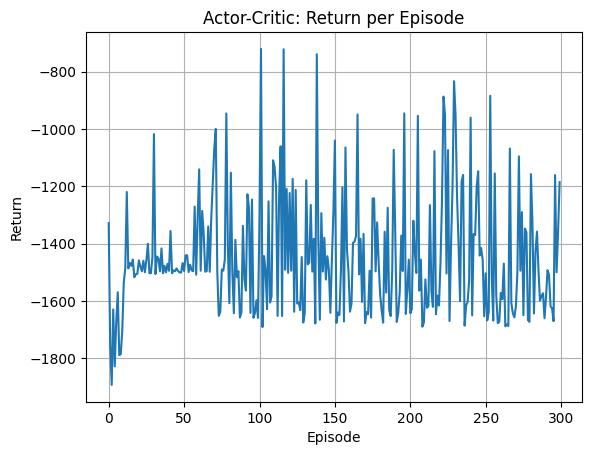

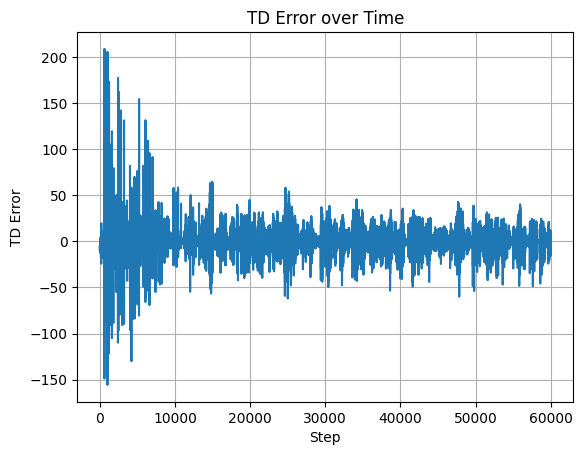

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt


# Actor Network (Gaussian Policy)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)

        self.mu = nn.Linear(64, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.mu(x)
        std = torch.exp(self.log_std)
        return mu, std



# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)



# Actor-Critic Training Loop
def train_actor_critic(episodes=300):
    env = gym.make("Pendulum-v1")

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    actor = Actor(state_dim, action_dim)
    critic = Critic(state_dim)

    actor_opt = optim.Adam(actor.parameters(), lr=0.0005)
    critic_opt = optim.Adam(critic.parameters(), lr=0.001)

    gamma = 0.99
    returns_list = []
    td_errors_list = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0

        while not done:
            state_t = torch.tensor(state, dtype=torch.float32)
            mu, std = actor(state_t)
            dist = Normal(mu, std)

            action = dist.sample()
            log_prob = dist.log_prob(action).sum()

            action_clipped = action.detach().numpy()
            action_clipped = np.clip(action_clipped, env.action_space.low, env.action_space.high)

            next_state, reward, terminated, truncated, _ = env.step(action_clipped)

            ep_return += reward

            # Critic update
            state_value = critic(state_t)
            next_value = critic(torch.tensor(next_state, dtype=torch.float32)).detach()

            td_error = reward + gamma * next_value - state_value
            td_errors_list.append(td_error.item())

            critic_loss = td_error.pow(2)

            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

            # Actor update
            actor_loss = -(log_prob * td_error.detach())

            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            state = next_state
            done = terminated or truncated

        returns_list.append(ep_return)

        if ep % 20 == 0:
            print(f"Episode {ep}, Return: {ep_return}")

    env.close()
    return returns_list, td_errors_list



# Run
returns, td_errors = train_actor_critic()

plt.plot(returns)
plt.title("Actor-Critic: Return per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.grid()
plt.show()

plt.plot(td_errors)
plt.title("TD Error over Time")
plt.xlabel("Step")
plt.ylabel("TD Error")
plt.grid()
plt.show()

torch.save(returns, "ac_returns.pt")


Episode 0, Return: -1169.80, Mean Entropy: 1.4283
Episode 20, Return: -1148.94, Mean Entropy: 1.4244
Episode 40, Return: -1231.72, Mean Entropy: 1.4408
Episode 60, Return: -1469.76, Mean Entropy: 1.4409
Episode 80, Return: -1445.93, Mean Entropy: 1.4250
Episode 100, Return: -1492.81, Mean Entropy: 1.4450
Episode 120, Return: -1231.05, Mean Entropy: 1.4723
Episode 140, Return: -1491.34, Mean Entropy: 1.4774
Episode 160, Return: -1345.55, Mean Entropy: 1.4629
Episode 180, Return: -1484.35, Mean Entropy: 1.4461
Episode 200, Return: -1617.57, Mean Entropy: 1.4533
Episode 220, Return: -1415.93, Mean Entropy: 1.4696
Episode 240, Return: -1478.38, Mean Entropy: 1.4834
Episode 260, Return: -1495.07, Mean Entropy: 1.4831
Episode 280, Return: -1462.89, Mean Entropy: 1.4566
Episode 300, Return: -1177.13, Mean Entropy: 1.4660
Episode 320, Return: -1332.76, Mean Entropy: 1.4467
Episode 340, Return: -1145.86, Mean Entropy: 1.4693
Episode 360, Return: -1500.09, Mean Entropy: 1.4431
Episode 380, Retur

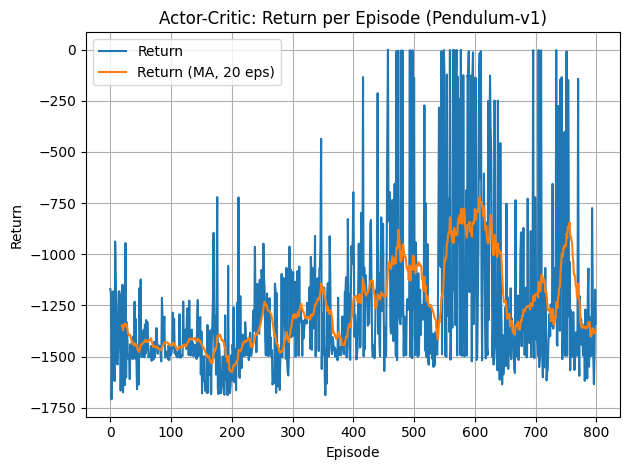

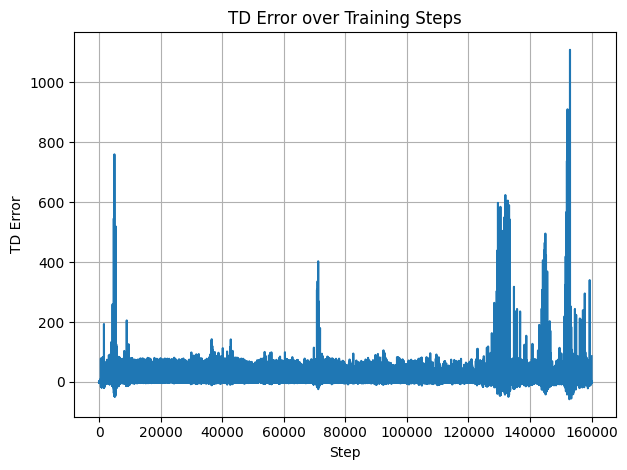

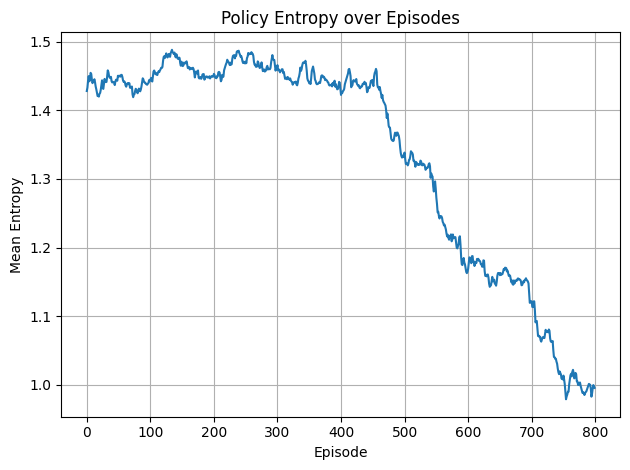

Training complete. Models and plots saved.


In [2]:
# Actor-Critic on Pendulum-v1 using PyTorch

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt



# Utility: set seeds (optional)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)



# Actor Network (Gaussian Policy)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)

        # Output mean for each action dimension
        self.mu = nn.Linear(64, action_dim)

        # Log standard deviation as a trainable parameter
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        mu = self.mu(x)
        std = torch.exp(self.log_std)  # must be positive

        return mu, std



# Critic Network (State Value)
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)



# Training Loop: Actor-Critic
def train_actor_critic(
    env_name="Pendulum-v1",
    episodes=800,
    gamma=0.99,
    actor_lr=3e-4,
    critic_lr=1e-3,
    reward_scale=0.1,
    beta_entropy=1e-3,
    print_every=20,
):
    set_seed(42)
    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    actor = Actor(state_dim, action_dim)
    critic = Critic(state_dim)

    actor_opt = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr)

    returns_list = []       # episode returns (original rewards)
    td_errors_list = []     # TD errors over steps
    entropy_list = []       # mean entropy per episode

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0.0
        ep_entropies = []

        while not done:
            state_t = torch.tensor(state, dtype=torch.float32)

            # ----- Actor: Gaussian policy -----
            mu, std = actor(state_t)
            dist = Normal(mu, std)

            action = dist.sample()
            log_prob = dist.log_prob(action).sum()
            entropy = dist.entropy().sum()
            ep_entropies.append(entropy.item())

            # Clip action to environment bounds
            action_np = action.detach().numpy()
            action_np = np.clip(
                action_np,
                env.action_space.low,
                env.action_space.high
            )

            next_state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated

            # Reward scaling for stability in gradients
            r = reward * reward_scale
            ep_return += reward  # keep original reward for logging

            # ----- Critic: TD target -----
            state_value = critic(state_t)

            if not done:
                next_state_t = torch.tensor(next_state, dtype=torch.float32)
                next_value = critic(next_state_t).detach()
                target = r + gamma * next_value
            else:
                target = torch.tensor(r, dtype=torch.float32)

            td_error = target - state_value
            td_errors_list.append(td_error.item())

            # ----- Critic update -----
            critic_loss = td_error.pow(2)

            critic_opt.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            critic_opt.step()

            # ----- Actor update -----
            actor_loss = -(log_prob * td_error.detach() + beta_entropy * entropy)

            actor_opt.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
            actor_opt.step()

            state = next_state

        returns_list.append(ep_return)
        mean_entropy = np.mean(ep_entropies) if ep_entropies else 0.0
        entropy_list.append(mean_entropy)

        if ep % print_every == 0:
            print(
                f"Episode {ep}, Return: {ep_return:.2f}, "
                f"Mean Entropy: {mean_entropy:.4f}"
            )

    env.close()
    return actor, critic, returns_list, td_errors_list, entropy_list



# Helper: moving average
def moving_average(x, window=20):
    if len(x) < window:
        return np.array(x)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)



# Main: train and plot
if __name__ == "__main__":
    actor, critic, returns, td_errors, entropies = train_actor_critic(
        env_name="Pendulum-v1",
        episodes=800,
        gamma=0.99,
        actor_lr=3e-4,
        critic_lr=1e-3,
        reward_scale=0.1,
        beta_entropy=1e-3,
        print_every=20,
    )

    # ----- Plot: Return per episode -----
    episodes = np.arange(len(returns))
    returns_ma = moving_average(returns, window=20)

    plt.figure()
    plt.plot(episodes, returns, label="Return")
    if len(returns_ma) > 0:
        plt.plot(
            episodes[len(episodes) - len(returns_ma):],
            returns_ma,
            label="Return (MA, 20 eps)",
        )
    plt.title("Actor-Critic: Return per Episode (Pendulum-v1)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ac_pendulum_returns.png")

    # ----- Plot: TD error over time -----
    plt.figure()
    plt.plot(td_errors)
    plt.title("TD Error over Training Steps")
    plt.xlabel("Step")
    plt.ylabel("TD Error")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ac_pendulum_td_error.png")

    # ----- Plot: Policy entropy over episodes -----
    plt.figure()
    plt.plot(entropies)
    plt.title("Policy Entropy over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Mean Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ac_pendulum_entropy.png")

    plt.show()

    # ----- Save trained models -----
    torch.save(actor.state_dict(), "actor_pendulum.pt")
    torch.save(critic.state_dict(), "critic_pendulum.pt")

    print("Training complete. Models and plots saved.")


## Extra Experiment summary

For the extra experiment, I kept the same Actor–Critic architecture but trained it longer on Pendulum-v1 and logged both the return and the mean policy entropy to better understand how the agent’s behavior changed over time. Early in training, the returns stayed very low (around −1100 to −1600) and the entropy was high (around 1.42–1.48), which matches a very exploratory policy that is still mostly random. As training went on, I started to see some much better episodes mixed in, such as returns near −700, then around −213, and even close to −140, which show that the agent sometimes finds policies that keep the pendulum closer to upright. At the same time, the entropy slowly decreased from about 1.4 down toward 1.0, meaning the policy became more confident and less random but did not collapse to a single action too quickly. The fact that good episodes appear later in training, along with a gradual drop in entropy, supports the idea that the combination of reward scaling, entropy regularization, and gradient clipping helped the Actor–Critic method learn a more effective continuous control policy, even though the returns are still noisy and not perfect.


## References

OpenAI. (2025). ChatGPT (Version 5.1) [Large language model]. https://chat.openai.com/